# **ALGORYTMY EWOLUCYJNE**
# Wykonawca - Levchenko Sofiia

## Wstęp
Na tym ćwiczeniu zajęliśmy się implementacją algorytmu genetycznego z selekcją ruletkową, krzyżowaniem jednopunktowym oraz sukcesją generacyjną. Zaimplementowany algorytm następnie zostanie przetestowany, poprzez zdefiniowanie funkcji celu na podstawie problemu *rakiety i ładowanego do niej paliwa* podanego w poleceniu.

### Wykorzystane narzędzia
W celu *implementacji* wyżej wspomnianego algorytmu, zostały wykorzystane pakie biblioteki jak `numpy` oraz `copy`.

 Pierwsza wspomniana biblioteka pozwala na swobodne posługiwanie się podstawowymi metodami obliczeń numerycznych. Biblioteka `copy` natomiast została wykorzystana w celu tworzenia kopii wartości zmiennych (a nie ich położenia w pamięci), w celu uniknięcia nieporządanego zachowania wykorzystywanych zmiennych. 

Kolejne biblioteki, czyli `pandas`, `matplotlib` oraz `tabulate` zostały wykorzystane do *przetworzenia* otrzymanych wyników oraz ich *wizualizacji* w postaci czytelnej dla człowieka.

In [ ]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt

## Implementacja algorytmu
Implementację algorytmu podzieliliśmy na dwie częsci. Najpierw zostałe zimplementowane *funkcje pomocnicze*, będące częścią samego algorytmu genetycznego:


*   **generate_population**, generującą populację o podanej liczebności i długości chromosomu
*   **generate_rate**, generującą poziom jakości każdego osobnika na podstawiee zdefiniowanej funkcji celu
*   **selection**, dokonującą selekcję ruletkową poprzez generację nowej populacji na podstawie wczęściej wyznaczonego poziomu jakości każdego osobnika
*   **crossover_and_mutation**, dokonującą mutację oraz krzyżowanie jednopunktowe całej populacji i wykorzystująca oddzielnie zdefiniowane funkcje *mutation* oraz *crossover*

In [ ]:
def generate_population(population_l, chromosome_l):
  i=0
  popupation = np.zeros((population_l, chromosome_l), dtype=int)
  while i<population_l:
    j=0
    used_indexes = []
    while j<chromosome_l:
      chance = np.random.rand()
      random_index = np.random.randint(0, chromosome_l)
      if (random_index not in used_indexes) and (chance<0.5):
        popupation[i][random_index] = 1
        used_indexes.append(random_index)
      j+=1
    i+=1
  return popupation

In [ ]:
def generate_rate(obj_func, curr_populat):
  i = 0
  j = 0
  values = []
  while i<len(curr_populat):
    values.append(obj_func(curr_populat[i]))
    i+=1
  min_value = np.min(values)
  if min_value<0:
    while j<len(values):
      values[j] = values[j] - min_value
      j+=1
  return np.array(values)

In [ ]:
def selection(curr_populat, rate):
  i = 0
  j = 0
  p_sel = []
  while i<len(curr_populat):
    value = 0
    if (np.sum(rate) - rate[i] != 0):
      value = rate[i]/(np.sum(rate) - rate[i])
    p_sel.append(value)
    i+=1
  new_populat = []
  while len(new_populat)<len(curr_populat):
    index = np.random.randint(0, len(curr_populat), dtype = int)
    rand = np.random.rand()
    if rand<p_sel[index]:
      new_populat.append(curr_populat[index])
  return np.array(new_populat)

In [ ]:
def crossover(parent_one, parent_two, len):
  crossover_point = np.random.randint(1, len)
  child_one = np.concatenate((parent_one[0:crossover_point], parent_two[crossover_point:len]), axis=None)
  child_two = np.concatenate((parent_two[0:crossover_point], parent_one[crossover_point:len]), axis=None)
  return np.array([child_one, child_two])

In [ ]:
def mutation(mutation_prob, unit):
  i = 0
  new_unit=np.array(unit)
  while i<len(new_unit):
    rand = np.random.rand()
    if rand<mutation_prob:
      new_unit[i]=1-new_unit[i]
    i+=1
  return new_unit

In [ ]:
def crossover_and_mutation(population, crossover_prob, mutation_prob):
  i = 0
  new_population = []
  indexes = np.arange(len(population))
  while len(new_population)<len(population):
    rand = np.random.rand()
    sel_indexes = np.random.choice(indexes, 2)
    if (rand<crossover_prob):
      new_children = crossover(population[sel_indexes[0]], population[sel_indexes[1]], len(population[sel_indexes[0]]))
      new_population.append(new_children[0])
      new_population.append(new_children[1])
    else: 
      new_population.append(population[sel_indexes[0]])
      new_population.append(population[sel_indexes[1]])
    indexes = np.setdiff1d(indexes, np.array([sel_indexes]))
  while i<len(new_population):
    new_population[i] = mutation(mutation_prob, new_population[i])
    i+=1
  return np.array(new_population)

Funkcja **problem_func** implementuję funkcję celu, opisaną w poleceniu do danego ćwiczenia. Po przeanalizowaniu treści polecenia, zostały wyodrębnione najważniejsze reguły zachowania danej funkcji:


*   Każdy gen, rozpatrywany jako jednostka czasowa, w danej funkcji jest interpretowany jako 1 sekunda czasu
*   Jeżeli w danej jednostce czasu jest wykorzystywane paliwo, to przyspieszenie podczas danej jednostki czasu wynosi a = 500/m - 0.06(V*|v|/m) - 0.9, a ilość paliwa znajdująca się w rakiecie jest zmniejszana o 1 jednostkę
*   Jeżeli w danej jednostce czasu nie jest wykorzystywane paliwo, to przyspieszenie w danej jednostce czasu wynosi a = - 0.06*velocity*(np.abs(velocity)/weight) - 0.9
*   Prędkość w czasie, zgodnie z zagadnieniami kinematyki, zmienia się według wzoru v=v0 + at, gdzie t jest równe 1 sekunda (zgodnie z 1 punktem na liście), więc ostateczna postać *liczbowa* to v = v0 + a
*   Osiągnieta wysokość, zgodnie z zagadnieniami kinematyki, zmienia się według wzoru s = v0t + at^2/2 , gdzie t jest równe 1 sekunda (zgodnie z 1 punktem na liście), więc ostateczna postać *liczbowa* to s = v0 + a/2


In [ ]:
def problem_func(unit):
  i = 0
  height = 0
  velocity = 0
  fuel = np.sum(unit)
  while i<len(unit):
    weight = 20 + fuel
    a = 0
    if unit[i]==1:
      a = 500/weight - 0.06*velocity*(np.abs(velocity)/weight) - 0.9
      fuel-=1
    else:
      a = - 0.06*velocity*(np.abs(velocity)/weight) - 0.9
    height += a/2 + velocity
    velocity += a 
    i+=1
  if height>=750:
    return 200 - np.sum(unit)
  else:
    return 0

## Testowanie algorytmu

### Określenie hiperparametrów i badanych funkcji
Aby uzyskane wyniki były wystarczająco dokładne, została dobrana *liczba iteracji*, *liczebność populacji*, *prawdopodobieństwo mutacji* oraz *prawdopodobieństwo krzyżowania*. 

In [ ]:
iterations = 1500 
population_len = 60 
chromosome_len = 200 
p_m = 0.1
p_c = 0.9 
alg_iter = 25

### Uruchomienie algorytmu dla z góry zdefiniowanych hiperparametrów

Następnie został zaimplementowany i uruchomiony algorytm dla opisane wcześniej zestawu parametrów. Algorytm został uruchomiony 25 razy, jako że z natury losowości generacji populacji i dokonania operacji selekcji populacji, wynik uzyskany po jednokrotnym uruchomieniu może być "skrajnym przypadkiem" i nie reprezentować w wystarczająco dobry sposób możliwości algorytmu


In [ ]:
j = 0
max_rates = []
while j<alg_iter:
  i = 0
  P = []
  P0 = generate_population(population_len, chromosome_len)
  rates = generate_rate(problem_func, P0)
  P.append(P0)
  while i<iterations:
    Tt = selection(P[len(P)-1], rates)
    Ot = crossover_and_mutation(Tt, p_c, p_m)
    rates = generate_rate(problem_func, Ot)
    P.append(Ot)
    i+=1
  max_rates.append(np.max(rates))
  j+=1
print("Wartości maksymalne zysku dla każdej z iteracji:")
print(max_rates)
print("Wynik uśredniony:")
print(np.average(np.array(max_rates)))

Wartości maksymalne zysku dla każdej z iteracji:
[121, 121, 120, 117, 124, 121, 119, 122, 117, 114, 119, 118, 117, 119, 121, 121, 115, 119, 116, 117, 116, 114, 112, 116, 116]
Wynik uśredniony:
118.08


## Badanie wpływu wybranych parametrów na wyniki

Jednym z zadań tego ćwiczenia laboratoryjnego było *zbadanie wpływu wybranegoo hiperparametru*. Została jednak podjęta decyzja, aby zbadać wpływ zarówno jak prawdopodobieństwa mutacji, tak i prawdopodobieństwa krzyżowania na wynik końcowy działania algorytmu.

### Badanie wpływu wartości prawdopodobieńctwa mutacji na wynik końcowy
Wpływ wartości prawdopodobieństwa został zbadany, poprzez wygenerowanie wyniku dla 9 różnych wartości tego hiperparametru: `0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9`. 

Podczas badania wartości pozostałych wyników wynosiły: prawdopodobieństwo krzyżowania równe 0.65, liczba iteracji równa 1500 i liczebność populacji równa 60. 

Z powodu tego, że eksperyment zajmuje około 5 godzin, aby nie czekać przez ten cały czas na próbki, wyniki uzyskane podczs jednego z eksperymentów zostały zapisane i zwizualizowane niżej.

In [ ]:
p_m = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_c = 0.65
j = 0
max_rates_p_m = np.zeros((len(p_m), alg_iter))
while j<len(p_m):
  k = 0
  while k<alg_iter:
    i = 0
    P = []
    P0 = generate_population(population_len, chromosome_len)
    rates = generate_rate(problem_func, P0)
    P.append(P0)
    while i<iterations:
      Tt = selection(P[len(P)-1], rates)
      Ot = crossover_and_mutation(Tt, p_c, p_m[j])
      rates = generate_rate(problem_func, Ot)
      P.append(Ot)
      i+=1
    max_rates_p_m[j][k] = np.max(rates)
    k+=1
  j+=1

In [ ]:
p_m = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_rates_p_m = [
[125, 127, 117, 116, 115, 115, 124, 123, 121, 191, 120, 118, 117, 122, 116, 119, 117, 117, 121, 119, 112, 116, 118, 114, 116], 
[114, 112, 124, 118, 118, 119, 115, 114, 124, 117, 114, 122, 118, 121, 115, 116, 114, 117, 113, 118, 116, 115, 121, 123, 116],
[121, 120, 119, 114, 119, 114, 117, 117, 119, 123, 114, 110, 123, 121, 113, 119, 118, 114, 120, 113, 119, 116, 118, 119, 113],
[113, 116, 117, 118, 118, 115, 113, 122, 122, 115, 114, 120, 115, 118, 116, 119, 114, 113, 122, 114, 112, 117, 115, 117, 119],
[119, 118, 119, 116, 123, 113, 118, 119, 113, 122, 120, 115, 112, 119, 119, 118, 111, 122, 123, 112, 113, 113, 115, 109, 117],
[115, 116, 115, 118, 111, 112, 123, 113, 116, 112, 113, 121, 112, 120, 115, 114, 118, 117, 118, 117, 118, 115, 115, 116, 112],
[117, 115, 116, 111, 116, 114, 118, 121, 116, 115, 119, 115, 116, 118, 112, 121, 117, 116, 115, 113, 116, 113, 111, 119, 116],
[115, 125, 112, 119, 115, 124, 112, 114, 114, 115, 112, 118, 115, 119, 110, 113, 116, 115, 115, 117, 119, 120, 115, 117, 113],
[122, 114, 117, 117, 115, 116, 114, 118, 122, 123, 119, 115, 116, 115, 114, 111, 114, 120, 112, 111, 114, 113, 133, 115, 120] 
]

Visialization of the influence of the parameter called probabilitty of mutation on the result



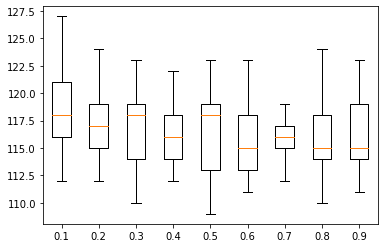

In [ ]:
print("Visialization of the influence of the parameter called probabilitty of mutation on the result", end="\n\n")
fig, ax = plt.subplots()
ax.boxplot(max_rates_p_m, showfliers=False)
plt.xticks([1,2,3,4,5,6,7,8,9], p_m)
plt.show()

### Badanie wpływu wartości prawdopodobieńctwa krzyżowania na wynik końcowy

Wpływ wartości prawdopodobieństwa został zbadany, poprzez wygenerowanie wyniku dla 9 różnych wartości tego hiperparametru: `0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9`. 

Podczas badania wartości pozostałych wyników wynosiły: prawdopodobieństwo mutacji równe 0.45, liczba iteracji równa 1500 i liczebność populacji równa 60. 

Z powodu tego, że eksperyment zajmuje około 5 godzin, aby nie czekać przez ten cały czas na próbki, wyniki uzyskane podczs jednego z eksperymentów zostały zapisane i zwizualizowane niżej.

In [ ]:
p_c = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_m = 0.45
j = 0
max_rates_p_c = np.zeros((len(p_c), alg_iter))
while j<len(p_c):
  k = 0
  while k<alg_iter:
    i = 0
    P = []
    P0 = generate_population(population_len, chromosome_len)
    rates = generate_rate(problem_func, P0)
    P.append(P0)
    while i<iterations:
      Tt = selection(P[len(P)-1], rates)
      Ot = crossover_and_mutation(Tt, p_c[j], p_m)
      rates = generate_rate(problem_func, Ot)
      P.append(Ot)
      i+=1
    max_rates_p_c[j][k] = np.max(rates)
    k+=1
  j+=1
print(max_rates_p_c)

In [ ]:
p_c = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_rates_p_c = [
[118, 115, 112, 124, 115, 115, 116, 124, 117, 113, 115, 117, 115, 113, 114, 114, 120, 112, 115, 119, 120, 118, 116, 115, 113],
[111, 114, 118, 118, 120, 117, 116, 113, 111, 119, 118, 115, 116, 116, 112, 116, 114, 112, 120, 118, 118, 116, 117, 111, 119],
[112, 113, 113, 115, 115, 113, 118, 117, 113, 116, 117, 114, 117, 112, 123, 118, 120, 114, 114, 114, 113, 116, 117, 114, 115],
[128, 116, 116, 113, 113, 116, 119, 125, 125, 117, 119, 116, 117, 113, 116, 116, 116, 118, 113, 115, 118, 113, 121, 113, 111],
[113, 116, 115, 117, 115, 120, 122, 113, 117, 115, 118, 119, 115, 116, 116, 117, 113, 117, 115, 119, 115, 117, 112, 119, 116],
[117, 117, 116, 115, 116, 118, 117, 116, 115, 115, 112, 117, 114, 111, 117, 113, 114, 117, 118, 121, 115, 113, 116, 118, 117],
[114, 118, 115, 114, 116, 116, 118, 117, 116, 116, 114, 115, 117, 113, 115, 117, 115, 114, 119, 118, 117, 112, 112, 115, 120],
[119, 119, 115, 116, 121, 118, 118, 120, 114, 118, 117, 113, 116, 115, 116, 121, 115, 120, 112, 119, 114, 115, 120, 115, 112],
[115, 120, 113, 116, 118, 114, 114, 116, 123, 122, 121, 123, 119, 117, 114, 120, 115, 113, 117, 114, 117, 114, 118, 118, 117]
]

Visialization of the influence of the parameter called probabilitty of crossover on the result



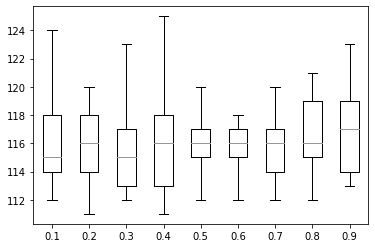

In [ ]:
print("Visialization of the influence of the parameter called probabilitty of crossover on the result", end="\n\n")
fig, ax = plt.subplots()
ax.boxplot(max_rates_p_c, showfliers=False)
plt.xticks([1,2,3,4,5,6,7,8,9], p_c)
plt.show()

## Wnioski i obserwacje
Na podstaiwe otrzymanych wyników można zrobić wniosek, że algorytm ten działa dosyć sprawnie, średnio osiągając w wyniku wartość około 118-119. Dla danego przypadku możemy zauważyć, że wartość prawdopodobieństwa mutacji miała nieco większy wpływ na otrzymany wynik, niż prawdopodobieństwo krzyżowania (rozrzut wartości jest większy dla różnych wartości tego parametru). Maksymalna wartość, którą udało się uzyskać podczas eksperymentu to 127, jednak pewnie istnieją rozwiązania lepsze od tego, przykładowo dla większej liczby iteracji lub innego zestawu hiperparametrów, niż wybrany w danej pracy (dobieranie wartości hiperparametrów w danym przypadku było zadaniem bardzo czasochłonnym i pewnie są sprytniejsze/zautomatyzowane sposoby na poszukiwanie tego najlepszego zestawu).